In [57]:
#어텐션을 이용한 텍스트 요약

In [58]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
np.random.seed(seed=0)


In [60]:
# Reviews.csv 파일을 data라는 이름의 데이터프레임에 저장. 단, 10만개의 행(rows)으로 제한.
data = pd.read_csv("C:/Users\kimchaeyeon\OneDrive - 서울여자대학교\바탕 화면\GDSC\Reviews.csv", nrows = 100000)
print('전체 리뷰 개수 :',(len(data)))


전체 리뷰 개수 : 100000


In [61]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [63]:
data=data[['Text','Summary']]
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [65]:
data.sample(10)

,Text,Summary
10655,All I can say is that our two dogs love these ...,Canine Testimonial
29762,I was very glad to finally find a way to recie...,Bigelow Tea
63784,I drink coffee for the flavor - I typically dr...,tastes like a good cup of coffee - albeit cold
10594,This quinoa has to be rinsed! I would not hav...,Directions say to rinse
20934,We have bought it now 3-4 times from amazon an...,very good
22540,This is my first review ever....I've been a Ph...,Ok..I know this isnt me
38438,Great product. Tastes amazing. I am in love wi...,Himalayan Crystal Salt - 1 lb.
4988,This is really good green tea without bitterne...,"Yes, It is Good"
17380,My kitty is a little messy so I needed one of ...,Great product
97537,Irish blend from Twining has a pleasing crisp ...,A great morning tea from Twining


In [66]:
#데이터 정제하기 
print('Text열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary열에서 중복을 배제한 유일한 샘플의 수:', data['Summary'].nunique())

Text열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary열에서 중복을 배제한 유일한 샘플의 수: 72348


In [69]:
#text 열에서 중복인 내용이 있다면 중복제거
data.drop_duplicates(subset=['Text'],inplace=True)
print('전체 샘플의수 :', len(data))

전체 샘플의수 : 88426


<ipython-input-69-64bb14fdc2f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(subset=['Text'],inplace=True)


In [71]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [72]:
#NULL값을 가진 샘플 제거
data.dropna(axis=0, inplace=True)
print('샘플의 수 :', len(data))

샘플의 수 : 88425


<ipython-input-72-9ef4d9ca1baa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(axis=0, inplace=True)


In [73]:
# 전처리 함수 내 사용
contractions = {"'cause": 'because',
 "I'd": 'I would',
 "I'd've": 'I would have',
 "I'll": 'I will',
 "I'll've": 'I will have',
 "I'm": 'I am',
 "I've": 'I have',
 "ain't": 'is not',
 "aren't": 'are not',
 "can't": 'cannot',
 "could've": 'could have',
 "couldn't": 'could not',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he would',
 "he'll": 'he will',
 "he's": 'he is',
 "here's": 'here is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how is',
 "i'd": 'i would',
 "i'd've": 'i would have',
 "i'll": 'i will',
 "i'll've": 'i will have',
 "i'm": 'i am',
 "i've": 'i have',
 "isn't": 'is not',
 "it'd": 'it would',
 "it'd've": 'it would have',
 "it'll": 'it will',
 "it'll've": 'it will have',
 "it's": 'it is',
 "let's": 'let us',
 "ma'am": 'madam',
 "mayn't": 'may not',
 "might've": 'might have',
 "mightn't": 'might not',
 "mightn't've": 'might not have',
 "must've": 'must have',
 "mustn't": 'must not',
 "mustn't've": 'must not have',
 "needn't": 'need not',
 "needn't've": 'need not have',
 "o'clock": 'of the clock',
 "oughtn't": 'ought not',
 "oughtn't've": 'ought not have',
 "sha'n't": 'shall not',
 "shan't": 'shall not',
 "shan't've": 'shall not have',
 "she'd": 'she would',
 "she'd've": 'she would have',
 "she'll": 'she will',
 "she'll've": 'she will have',
 "she's": 'she is',
 "should've": 'should have',
 "shouldn't": 'should not',
 "shouldn't've": 'should not have',
 "so's": 'so as',
 "so've": 'so have',
 "that'd": 'that would',
 "that'd've": 'that would have',
 "that's": 'that is',
 "there'd": 'there would',
 "there'd've": 'there would have',
 "there's": 'there is',
 "they'd": 'they would',
 "they'd've": 'they would have',
 "they'll": 'they will',
 "they'll've": 'they will have',
 "they're": 'they are',
 "they've": 'they have',
 "this's": 'this is',
 "to've": 'to have',
 "wasn't": 'was not',
 "we'd": 'we would',
 "we'd've": 'we would have',
 "we'll": 'we will',
 "we'll've": 'we will have',
 "we're": 'we are',
 "we've": 'we have',
 "weren't": 'were not',
 "what'll": 'what will',
 "what'll've": 'what will have',
 "what're": 'what are',
 "what's": 'what is',
 "what've": 'what have',
 "when's": 'when is',
 "when've": 'when have',
 "where'd": 'where did',
 "where's": 'where is',
 "where've": 'where have',
 "who'll": 'who will',
 "who'll've": 'who will have',
 "who's": 'who is',
 "who've": 'who have',
 "why's": 'why is',
 "why've": 'why have',
 "will've": 'will have',
 "won't": 'will not',
 "won't've": 'will not have',
 "would've": 'would have',
 "wouldn't": 'would not',
 "wouldn't've": 'would not have',
 "y'all": 'you all',
 "y'all'd": 'you all would',
 "y'all'd've": 'you all would have',
 "y'all're": 'you all are',
 "y'all've": 'you all have',
 "you'd": 'you would',
 "you'd've": 'you would have',
 "you'll": 'you will',
 "you'll've": 'you will have',
 "you're": 'you are',
 "you've": 'you have'}


In [76]:
#NLTk 불용어
stop_words= set(stopwords.words('english'))
print('불용어 개수:', len(stop_words))
print(stop_words)

불용어 개수: 179
{'him', 's', 'under', "you're", "you'll", 'such', 'won', 'further', 'up', 'itself', "that'll", 'your', 'where', "couldn't", "aren't", "isn't", 'yourselves', 'needn', 'too', 'most', 'me', 'because', 'above', "shan't", 'y', 'wouldn', 'is', 'after', 'an', 'all', 'did', 'doesn', 'very', "won't", 'than', 'yours', 'if', 'our', 'are', 'but', 'when', 'was', 'so', 'o', 'on', 'other', 'will', 'few', "wouldn't", 'for', "didn't", "doesn't", 'then', 'has', "shouldn't", "you'd", 'hadn', 'the', 'yourself', 'weren', "wasn't", 'their', "mightn't", 'do', 'each', 'wasn', 'own', 'through', 'mustn', 'and', "weren't", 'before', 'doing', 'whom', 'into', 'couldn', 'how', 'them', 'himself', 'am', 've', 'ourselves', 'didn', 'from', 'we', "it's", 'those', 'its', 'nor', 'you', 'can', 'not', 'who', 'these', 'during', 'to', 'between', 'by', 'isn', 'have', 'only', 'be', 'having', 'more', "haven't", 'this', 'that', 'same', 'below', 'again', 'shouldn', "you've", 'just', 'both', "hasn't", 'off', 'until', 'd

In [77]:
# 전처리 함수
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens


In [78]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))


everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [79]:
# Text 열 전처리
clean_text = []
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))
clean_text[:5]


<ipython-input-77-486d11b728f3>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [80]:
# Summary 열 전처리
clean_summary = []
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:5]


<ipython-input-77-486d11b728f3>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
<ipython-input-77-486d11b728f3>:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [81]:
data['Text']= clean_text
data['Summary']= clean_summary

In [82]:
#길이가 공백인 샘플은 NULL 값으로 변환
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

Text        0
Summary    70
dtype: int64


In [84]:
data.dropna(axis=0,inplace=True)
print('전체 샘플의 수 ', len(data))

전체 샘플의 수  88355


텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


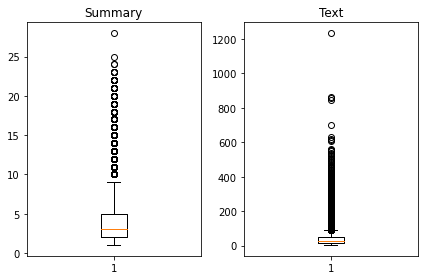

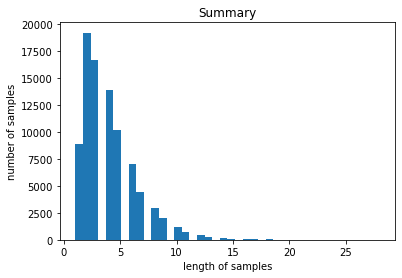

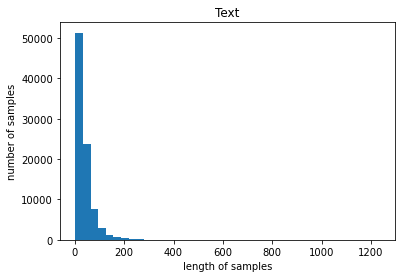

In [85]:
#길이 분포 출력
text_len= [len(s.split()) for s in data['Text']]
summary_len= [len(s.split()) for s in data['Summary']]
print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [86]:
text_max_len= 50
summary_max_len= 8

In [87]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


In [88]:
below_threshold_len(text_max_len, data['Text'])


전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859


In [89]:
below_threshold_len(summary_max_len, data['Summary'])


전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


In [90]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 65818


In [91]:
data.head()


,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


In [129]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [130]:
encoder_input = np.array(data['Text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

In [131]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[46156  4525 36446 ... 50667 57032 40260]


In [132]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]


In [133]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)


테스트 데이터의 수 : 13163


In [134]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]


In [135]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))


훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


In [136]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)


In [137]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 31971
등장 빈도가 6번 이하인 희귀 단어의 수: 23751
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8220
단어 집합에서 희귀 단어의 비율: 74.28919958712584
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.392742057961868


In [138]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)


In [139]:
print(encoder_input_train[:3])


[[1295, 11, 27, 149, 76, 1762, 445, 752, 1295, 11], [34, 142, 8, 646, 262, 275, 16, 89, 8, 63, 42, 112, 647, 241, 61, 12, 102, 9, 131, 21, 305, 743, 8, 8, 3, 9, 271, 337, 427, 8, 448, 113, 8, 92, 2, 8, 727, 95, 98, 8, 8, 290], [1, 886, 181, 10, 13, 814, 466, 1527, 746, 778, 88, 193, 615, 1485, 973, 465, 19, 1070, 149, 1151, 442, 283, 78, 1854, 3399, 904, 579, 1399, 629]]


In [140]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)


In [141]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 10553
등장 빈도가 5번 이하인 희귀 단어의 수: 8163
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2390
단어 집합에서 희귀 단어의 비율: 77.35241163650147
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.925039597823841


In [106]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)


In [107]:
print(encoder_input_train[:3])


[[279, 255, 110, 273, 95, 101, 42, 878, 9, 24, 112, 875, 63, 7, 39, 16, 375, 7, 77, 203, 42, 26, 120, 402, 1732, 306, 95, 101, 42, 71, 321, 5, 299, 134, 93, 1185, 738, 1016, 218, 2568, 4179, 206, 1635, 1499, 6], [3, 158, 104, 104, 466, 49, 31, 7, 726, 7, 47, 1, 329, 158, 1197, 1690, 643, 329, 69, 2302, 157, 3401, 551, 69, 1249, 29, 1205, 28, 773, 29, 496, 158, 21, 16, 29, 111, 3251, 3, 634, 180, 1, 568], [111, 2, 1406, 523, 21, 158, 568, 1406, 185, 351]]


In [108]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)


In [109]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 10530
등장 빈도가 5번 이하인 희귀 단어의 수: 8115
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2415
단어 집합에서 희귀 단어의 비율: 77.06552706552706
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.847140336532255


In [142]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)


In [143]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)


In [144]:
print(decoder_input_train[:5])


[[1, 68, 29, 14], [1, 64, 837, 15, 13], [1, 593, 983], [1, 33, 1797], [1, 425, 287]]


In [145]:
print(decoder_target_train[:5])


[[68, 29, 14, 2], [64, 837, 15, 13, 2], [593, 983, 2], [33, 1797, 2], [425, 287, 2]]


In [146]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]


In [147]:
print('삭제할 훈련 데이터의 개수', len(drop_train))
print('삭제할 테스트 데이터의 개수', len(drop_test))

삭제할 훈련 데이터의 개수 1277
삭제할 테스트 데이터의 개수 315


In [148]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (52655,) + inhomogeneous part.

In [96]:
import numpy as np
import gensim
from urllib.request import urlretrieve, urlopen
import gzip
import zipfile

In [97]:
urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", filename="glove.6B.zip")
zf = zipfile.ZipFile('glove.6B.zip')
zf.extractall() 
zf.close()

In [98]:
glove_dict = dict()
f = open('glove.6B.100d.txt', encoding="utf8") # 100차원의 GloVe 벡터를 사용

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
    glove_dict[word] = word_vector_arr
f.close()

In [7]:
glove_dict['cat']

array([ 0.23088  ,  0.28283  ,  0.6318   , -0.59411  , -0.58599  ,
        0.63255  ,  0.24402  , -0.14108  ,  0.060815 , -0.7898   ,
       -0.29102  ,  0.14287  ,  0.72274  ,  0.20428  ,  0.1407   ,
        0.98757  ,  0.52533  ,  0.097456 ,  0.8822   ,  0.51221  ,
        0.40204  ,  0.21169  , -0.013109 , -0.71616  ,  0.55387  ,
        1.1452   , -0.88044  , -0.50216  , -0.22814  ,  0.023885 ,
        0.1072   ,  0.083739 ,  0.55015  ,  0.58479  ,  0.75816  ,
        0.45706  , -0.28001  ,  0.25225  ,  0.68965  , -0.60972  ,
        0.19578  ,  0.044209 , -0.31136  , -0.68826  , -0.22721  ,
        0.46185  , -0.77162  ,  0.10208  ,  0.55636  ,  0.067417 ,
       -0.57207  ,  0.23735  ,  0.4717   ,  0.82765  , -0.29263  ,
       -1.3422   , -0.099277 ,  0.28139  ,  0.41604  ,  0.10583  ,
        0.62203  ,  0.89496  , -0.23446  ,  0.51349  ,  0.99379  ,
        1.1846   , -0.16364  ,  0.20653  ,  0.73854  ,  0.24059  ,
       -0.96473  ,  0.13481  , -0.0072484,  0.33016  , -0.1236

In [ ]:
!pip install fasttext

In [ ]:
# 300차원의 FastText 벡터 사용
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
ft.get_word_vector('cat')

In [ ]:
# 300차원의 Word2Vec 벡터 사용
urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
                           filename="GoogleNews-vectors-negative300.bin.gz")
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
word2vec_model['cat']

In [9]:
#문장임베딩
embedding_dim=100
zero_vector =np.zeros(embedding_dim)

In [10]:
# 단어 벡터의 평균으로부터 문장 벡터를 얻는다.
def calculate_sentence_vector(sentence):
  return sum([glove_dict.get(word, zero_vector) 
                  for word in sentence])/len(sentence)

In [11]:
eng_sent = ['I', 'am', 'a', 'student']
sentence_vector = calculate_sentence_vector(eng_sent)
print(len(sentence_vector))

100


In [13]:
kor_sent = ['전', '좋은', '학생', '입니다']
sentence_vector = calculate_sentence_vector(kor_sent)
print(sentence_vector)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [8]:
#4.텍스트 랭크를 이용한 텍스트 요약

In [33]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from urllib.request import urlretrieve
import zipfile
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx


In [34]:
stop_words = stopwords.words('english')

In [35]:
urlretrieve("https://raw.githubusercontent.com/prateekjoshi565/textrank_text_summarization/master/tennis_articles_v4.csv", filename="tennis_articles_v4.csv")
data = pd.read_csv("tennis_articles_v4.csv")
data.head()

,article_id,article_text,source
0,1,Maria Sharapova has basically no friends as te...,https://www.tennisworldusa.org/tennis/news/Mar...
1,2,"BASEL, Switzerland (AP), Roger Federer advance...",http://www.tennis.com/pro-game/2018/10/copil-s...
2,3,Roger Federer has revealed that organisers of ...,https://scroll.in/field/899938/tennis-roger-fe...
3,4,Kei Nishikori will try to end his long losing ...,http://www.tennis.com/pro-game/2018/10/nishiko...
4,5,"Federer, 37, first broke through on tour over ...",https://www.express.co.uk/sport/tennis/1036101...


In [36]:
data = data[['article_text']]
data['sentences'] = data['article_text'].apply(sent_tokenize)
data


,article_text,sentences
0,Maria Sharapova has basically no friends as te...,[Maria Sharapova has basically no friends as t...
1,"BASEL, Switzerland (AP), Roger Federer advance...","[BASEL, Switzerland (AP), Roger Federer advanc..."
2,Roger Federer has revealed that organisers of ...,[Roger Federer has revealed that organisers of...
3,Kei Nishikori will try to end his long losing ...,[Kei Nishikori will try to end his long losing...
4,"Federer, 37, first broke through on tour over ...","[Federer, 37, first broke through on tour over..."
5,Nadal has not played tennis since he was force...,[Nadal has not played tennis since he was forc...
6,"Tennis giveth, and tennis taketh away. The end...","[Tennis giveth, and tennis taketh away., The e..."
7,Federer won the Swiss Indoors last week by bea...,[Federer won the Swiss Indoors last week by be...


In [37]:
# 토큰화 함수
def tokenization(sentences):
    return [word_tokenize(sentence) for sentence in sentences]

# 전처리 함수
def preprocess_sentence(sentence):
  # 영어를 제외한 숫자, 특수 문자 등은 전부 제거. 모든 알파벳은 소문자화
  sentence = [re.sub(r'[^a-zA-z\s]', '', word).lower() for word in sentence]
  # 불용어가 아니면서 단어가 실제로 존재해야 한다.
  return [word for word in sentence if word not in stop_words and word]

# 위 전처리 함수를 모든 문장에 대해서 수행. 이 함수를 호출하면 모든 행에 대해서 수행.
def preprocess_sentences(sentences):
    return [preprocess_sentence(sentence) for sentence in sentences]


In [38]:
data['tokenized_sentences'] = data['sentences'].apply(tokenization)
data['tokenized_sentences'] = data['tokenized_sentences'].apply(preprocess_sentences)
data


,article_text,sentences,tokenized_sentences
0,Maria Sharapova has basically no friends as te...,[Maria Sharapova has basically no friends as t...,"[[maria, sharapova, basically, friends, tennis..."
1,"BASEL, Switzerland (AP), Roger Federer advance...","[BASEL, Switzerland (AP), Roger Federer advanc...","[[basel, switzerland, ap, roger, federer, adva..."
2,Roger Federer has revealed that organisers of ...,[Roger Federer has revealed that organisers of...,"[[roger, federer, revealed, organisers, relaun..."
3,Kei Nishikori will try to end his long losing ...,[Kei Nishikori will try to end his long losing...,"[[kei, nishikori, try, end, long, losing, stre..."
4,"Federer, 37, first broke through on tour over ...","[Federer, 37, first broke through on tour over...","[[federer, first, broke, tour, two, decades, a..."
5,Nadal has not played tennis since he was force...,[Nadal has not played tennis since he was forc...,"[[nadal, played, tennis, since, forced, retire..."
6,"Tennis giveth, and tennis taketh away. The end...","[Tennis giveth, and tennis taketh away., The e...","[[tennis, giveth, tennis, taketh, away], [end,..."
7,Federer won the Swiss Indoors last week by bea...,[Federer won the Swiss Indoors last week by be...,"[[federer, swiss, indoors, last, week, beating..."


In [39]:
embedding_dim=100
zero_vector= np.zeros(embedding_dim)

In [40]:
#단어 벡터의 평균으로부터 문장 벡터를 얻는다.
def calculate_sentence_vector(sentence):
    if len(sentence) !=0:
        return sum([glove_dict.get(word,zero_vector)
                   for word in sentence])/len(sentence)
    else:
        return zero_vector

In [41]:
# 각 문장에 대해서 문장 벡터를 반환
def sentences_to_vectors(sentences):
    return [calculate_sentence_vector(sentence) 
              for sentence in sentences]


In [42]:
data['SentenceEmbedding'] = data['tokenized_sentences'].apply(sentences_to_vectors)
data[['SentenceEmbedding']]

,SentenceEmbedding
0,"[[0.051488996, 0.1105585, 0.6950863, 0.1891917..."
1,"[[0.10566062456928194, -0.10534465219825506, 0..."
2,"[[-0.022272188, -0.0474477, 0.14933074, -0.086..."
3,"[[0.045201838, -0.064647146, 0.5035717, -0.160..."
4,"[[0.21536233, 0.180915, 0.25600883, 0.06924241..."
5,"[[0.04484453, -0.0074302587, 0.33349112, -0.07..."
6,"[[-0.115338005, -0.0062844106, 0.595185, -0.16..."
7,"[[0.0740439, 0.059211146, 0.49143884, 0.216771..."


In [43]:
def similarity_matrix(sentence_embedding):
  sim_mat = np.zeros([len(sentence_embedding), len(sentence_embedding)])
  for i in range(len(sentence_embedding)):
      for j in range(len(sentence_embedding)):
        sim_mat[i][j] = cosine_similarity(sentence_embedding[i].reshape(1, embedding_dim),
                                          sentence_embedding[j].reshape(1, embedding_dim))[0,0]
  return sim_mat


In [44]:
data['SimMatrix'] = data['SentenceEmbedding'].apply(similarity_matrix)
data['SimMatrix']

0    [[1.0, 0.6477208137512207, 0.5915699601173401,...
1    [[1.0000000000000002, 0.8745531210608369, 0.80...
2    [[0.9999999403953552, 0.9130854606628418, 0.89...
3    [[1.0, 0.7769179305294039, 0.8405090570449829,...
4    [[0.9999999403953552, 0.8306209732530097, 0.90...
5    [[1.0, 0.8843014240264893, 0.8540289072721128,...
6    [[1.0, 0.4730549156665802, 0.45002689957618713...
7    [[1.0000001192092896, 0.7634095600081803, 0.78...
Name: SimMatrix, dtype: object

In [45]:
print('두번째 샘플의 문장 개수 :',len(data['tokenized_sentences'][1]))
print('두번째 샘플의 문장 벡터가 모인 문장 행렬의 크기(shape) :',np.shape(data['SentenceEmbedding'][1]))
print('두번째 샘플의 유사도 행렬의 크기(shape) :',data['SimMatrix'][1].shape)

두번째 샘플의 문장 개수 : 12
두번째 샘플의 문장 벡터가 모인 문장 행렬의 크기(shape) : (12, 100)
두번째 샘플의 유사도 행렬의 크기(shape) : (12, 12)


In [46]:
def draw_graphs(sim_matrix):
  nx_graph = nx.from_numpy_array(sim_matrix)
  plt.figure(figsize=(10, 10))
  pos = nx.spring_layout(nx_graph)
  nx.draw(nx_graph, with_labels=True, font_weight='bold')
  nx.draw_networkx_edge_labels(nx_graph,pos,font_color='red')
  plt.show()

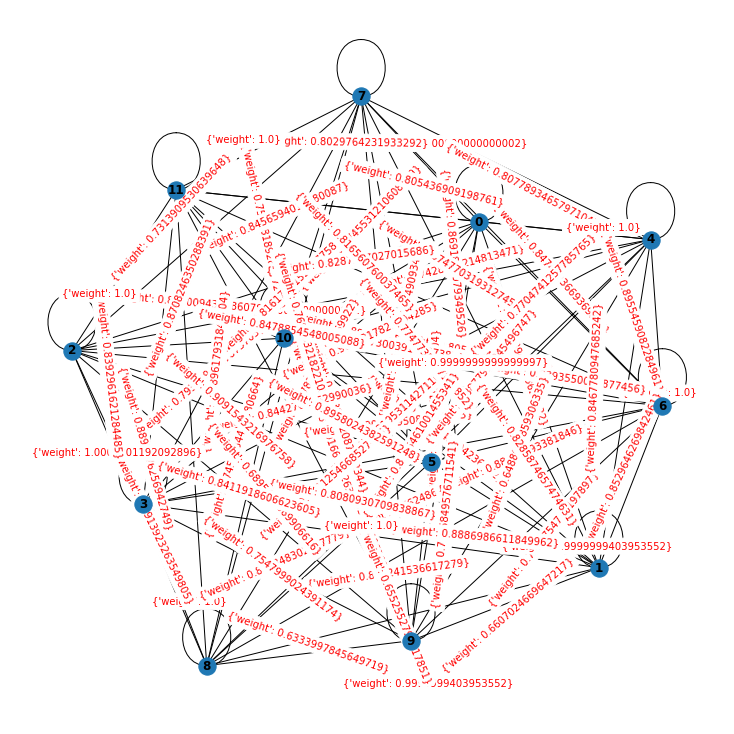

In [47]:
draw_graphs(data['SimMatrix'][1])

In [48]:
def calculate_score(sim_matrix):
    nx_graph = nx.from_numpy_array(sim_matrix)
    scores = nx.pagerank(nx_graph)
    return scores

In [49]:
data['score'] = data['SimMatrix'].apply(calculate_score)
data[['SimMatrix', 'score']]

,SimMatrix,score
0,"[[1.0, 0.6477208137512207, 0.5915699601173401,...","{0: 0.054921591022489724, 1: 0.062865197049714..."
1,"[[1.0000000000000002, 0.8745531210608369, 0.80...","{0: 0.08315094403669274, 1: 0.0849861133324111..."
2,"[[0.9999999403953552, 0.9130854606628418, 0.89...","{0: 0.06148440541188735, 1: 0.0622486438747321..."
3,"[[1.0, 0.7769179305294039, 0.8405090570449829,...","{0: 0.0816472843064401, 1: 0.07276479393776236..."
4,"[[0.9999999403953552, 0.8306209732530097, 0.90...","{0: 0.05568689695719614, 1: 0.0509923172102180..."
5,"[[1.0, 0.8843014240264893, 0.8540289072721128,...","{0: 0.08288694340822064, 1: 0.0840376035097743..."
6,"[[1.0, 0.4730549156665802, 0.45002689957618713...","{0: 0.073362518349706, 1: 0.10508890109111275,..."
7,"[[1.0000001192092896, 0.7634095600081803, 0.78...","{0: 0.04321039503441401, 1: 0.0473333979125727..."


In [50]:
data['score'][1]

{0: 0.08315094403669274,
 1: 0.08498611333241113,
 2: 0.08555019713358379,
 3: 0.08383717228551156,
 4: 0.08137939981770781,
 5: 0.08439284996237834,
 6: 0.08507725749398774,
 7: 0.08092839166279345,
 8: 0.0745404602246977,
 9: 0.0853583713993361,
 10: 0.08498242760023653,
 11: 0.08581641505066301}

In [51]:
def ranked_sentences(sentences, scores, n=3):
    top_scores = sorted(((scores[i],s) 
                         for i,s in enumerate(sentences)), 
                                reverse=True)
    top_n_sentences = [sentence 
                        for score,sentence in top_scores[:n]]
    return " ".join(top_n_sentences)


In [53]:
data['summary']= data.apply(lambda x: 
                            ranked_sentences(x.sentences,
                            x.score), axis=1)

In [54]:
for i in range(0, len(data)):
  print(i+1,'번 문서')
  print('원문 :',data.loc[i].article_text)
  print('')
  print('요약 :',data.loc[i].summary)
  print('')


1 번 문서
원문 : Maria Sharapova has basically no friends as tennis players on the WTA Tour. The Russian player has no problems in openly speaking about it and in a recent interview she said: 'I don't really hide any feelings too much. I think everyone knows this is my job here. When I'm on the courts or when I'm on the court playing, I'm a competitor and I want to beat every single person whether they're in the locker room or across the net.So I'm not the one to strike up a conversation about the weather and know that in the next few minutes I have to go and try to win a tennis match. I'm a pretty competitive girl. I say my hellos, but I'm not sending any players flowers as well. Uhm, I'm not really friendly or close to many players. I have not a lot of friends away from the courts.' When she said she is not really close to a lot of players, is that something strategic that she is doing? Is it different on the men's tour than the women's tour? 'No, not at all. I think just because you're i